# 2. Factor investing and asset pricing anomalies

In [87]:
# Imports
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [88]:
DATA_PATH = "../data/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


### 3.2.2 Simple portfolio sorts

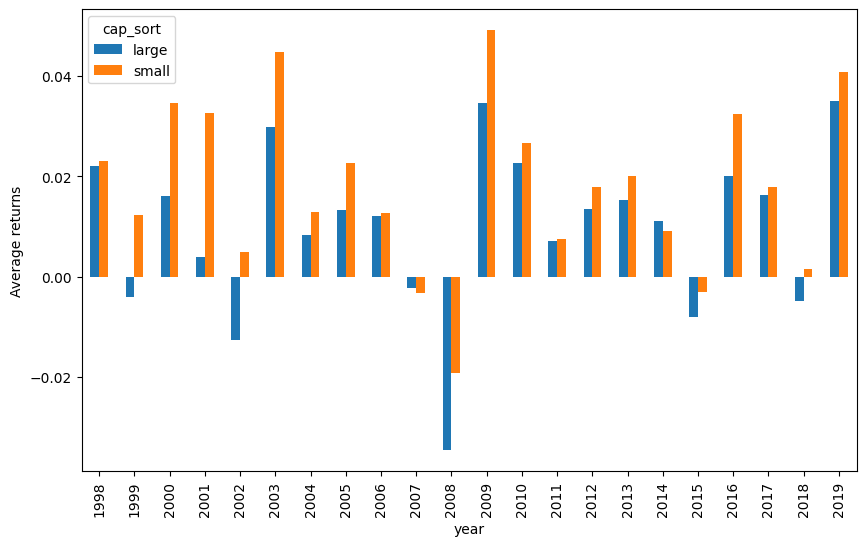

In [89]:
df_median=[]          #creating empty placeholder for temporary dataframe
df=[]       
df_median=data_ml[['date','Mkt_Cap_12M_Usd']].groupby(['date']).median().reset_index() # computing median
df_median.rename(columns = {'Mkt_Cap_12M_Usd': 'cap_median'}, inplace = True) # renaming for clarity
df = pd.merge(data_ml[["date",'Mkt_Cap_12M_Usd','R1M_Usd']],df_median,how='left', on=['date']) 
df=df.groupby([pd.to_datetime(df['date']).dt.year,np.where(df['Mkt_Cap_12M_Usd'] > df['cap_median'], 'large', 'small')])['R1M_Usd'].mean().reset_index() # groupby and defining "year" and cap logic
df.rename(columns = {'level_1': 'cap_sort'}, inplace = True) 
df.pivot(index='date',columns='cap_sort',values='R1M_Usd').plot.bar(figsize=(10,6))
plt.ylabel('Average returns')
plt.xlabel('year')    
df_median=[]          #removing the temp dataframe to keep it light!
df=[]                 #removing the temp dataframe to keep it light!

### 3.2.3 Factors

In [90]:
min_date = '1998-11-30'
max_date = '2019-03-31'

FF_DATA_PATH = "../data/F-F_Research_Data_5_Factors_2x3.csv"

df_ff = pd.read_csv(FF_DATA_PATH, header=3, sep=',', quotechar='"', nrows=747)
df_ff.rename(columns = {'Mkt-RF':'MKT_RF', 'Unnamed: 0':'Date'}, inplace = True) # renaming for clarity
# Convert the Date column to datetime using pandas (Series has no .to_datetime())
df_ff['Date'] = pd.to_datetime(df_ff['Date'], format='%Y%m', errors='coerce')
df_ff.rename(columns={'Date': 'date'}, inplace=True)
df_ff.set_index('date', inplace=True)
df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']]=df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']]/100.0 # Scale returns
df_ff['year']=df_ff.index.year
idx_ff = df_ff.index[(df_ff.index >= min_date) & (df_ff.index <= max_date)].tolist()
FF_factors = df_ff.loc[idx_ff]
FF_factors = FF_factors.drop(columns=['date_int'], errors='ignore')

FF_factors.head()

,MKT_RF,SMB,HML,RMW,CMA,RF,year
date,,,,,,,
1998-12-01,0.0615,-0.0150,-0.0425,-0.0069,-0.0326,0.0038,1998
1999-01-01,0.0347,-0.0082,-0.0446,-0.0280,-0.0641,0.0035,1999
1999-02-01,-0.0408,-0.0515,0.0195,-0.0123,0.0408,0.0035,1999
1999-03-01,0.0348,-0.0437,-0.0261,-0.0405,-0.0107,0.0043,1999
1999-04-01,0.0434,0.0452,0.0240,-0.0247,0.0084,0.0037,1999


Text(0.5, 0, 'date')

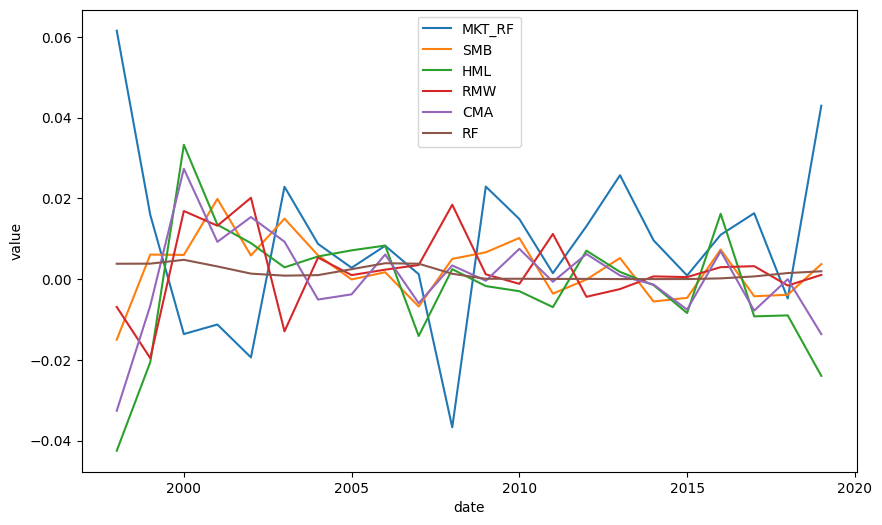

In [91]:
FF_factors.groupby(FF_factors['year']).mean().plot(figsize=(10,6)) # groupby and defining "year" and cap logic
plt.ylabel('value')
plt.xlabel('date')

### 3.2.5 Fama-Macbeth regressions

In [92]:
# Create returns pivot
returns = data_ml.pivot(index='date', columns='stock_id', values='R1M_Usd')
returns = returns.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Prepare FF_factors - reset index to get 'date' column
FF_factors_merge = FF_factors.reset_index()

# Create merge key using year-month period
returns_reset = returns.reset_index()
returns_reset['year_month'] = returns_reset['date'].dt.to_period('M')
FF_factors_merge['year_month'] = FF_factors_merge['date'].dt.to_period('M')

# Merge on year-month period
factor_columns = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']
data_FM = pd.merge(
    returns_reset, 
    FF_factors_merge[['year_month'] + factor_columns], 
    how='inner', 
    on='year_month'
)
data_FM = data_FM.drop(columns=['year_month'])
data_FM = data_FM.set_index('date')

# Run factor regressions
stocks_list = [col for col in data_FM.columns if col not in factor_columns]
df_res_full = []

for stock_id in stocks_list:
    # Get stock returns and shift to next period
    Y = data_FM[stock_id].shift(-1)
    X = data_FM[factor_columns]
    
    # Drop rows where either Y or X has NaN (this aligns the indices)
    valid_idx = Y.notna() & X.notna().all(axis=1)
    Y_clean = Y[valid_idx]
    X_clean = X[valid_idx]
    
    if len(Y_clean) < 12:  # Skip stocks with insufficient data
        continue
    
    try:
        results = sm.OLS(endog=Y_clean, exog=sm.add_constant(X_clean)).fit()
        results_df = pd.DataFrame(results.params).T
        results_df['stock_id'] = stock_id
        df_res_full.append(results_df)
    except Exception as e:
        continue

if len(df_res_full) == 0:
    raise ValueError(f"No successful regressions. Periods: {data_FM.shape[0]}, Stocks: {len(stocks_list)}")

# Format results
df_res_full = pd.concat(df_res_full, ignore_index=True)
df_res_full = df_res_full.set_index('stock_id')
column_names = ["const", "MKT_RF", "SMB", "HML", "RMW", "CMA"]
reg_result = df_res_full[column_names]

print(f'Factor betas: {reg_result.shape[0]} stocks')
reg_result

Factor betas: 1206 stocks


,const,MKT_RF,SMB,HML,RMW,CMA
stock_id,,,,,,
1,0.020119,0.006427,-0.135427,-0.122068,0.168988,0.342441
2,0.013172,0.244481,0.008035,-1.080963,0.293453,0.443798
3,0.008585,-0.245505,-0.104004,0.107710,-0.219461,-0.234989
4,0.010451,-0.037487,-0.033027,0.038901,-0.308743,0.107061
5,0.022055,-0.527739,-0.099329,-0.279561,-0.347978,-0.185443
...,...,...,...,...,...,...
1208,0.013867,0.099707,0.707185,-0.219358,0.824261,-0.652116
1209,0.014495,-0.507979,-0.130069,0.046079,-0.249469,0.357860
1210,0.015675,-0.126677,-0.228582,-0.097361,-0.324100,0.207025


In [93]:
returns_trsp=returns.transpose()
df_2nd_pass=pd.concat([reg_result.iloc[:,1:6], returns.transpose()], axis=1)
df_2nd_pass.head()

,MKT_RF,SMB,HML,RMW,CMA,1998-11-30 00:00:00,1998-12-31 00:00:00,1999-01-31 00:00:00,1999-02-28 00:00:00,1999-03-31 00:00:00,...,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00,2019-01-31 00:00:00,2019-02-28 00:00:00,2019-03-31 00:00:00
stock_id,,,,,,,,,,,,,,,,,,,,,
1,0.006427,-0.135427,-0.122068,0.168988,0.342441,-0.340,-0.057,-0.352,0.494,0.461,...,0.000,-0.077,-0.002,-0.155,0.014,-0.110,0.082,0.013,NaN,NaN
2,0.244481,0.008035,-1.080963,0.293453,0.443798,0.646,0.111,-0.471,-0.098,0.965,...,-0.021,-0.031,-0.009,-0.044,-0.136,-0.079,0.090,0.123,NaN,NaN
3,-0.245505,-0.104004,0.107710,-0.219461,-0.234989,0.016,-0.028,0.004,-0.060,0.071,...,-0.039,0.033,-0.049,-0.070,0.036,-0.070,0.030,0.046,-0.046,0.031
4,-0.037487,-0.033027,0.038901,-0.308743,0.107061,-0.088,-0.081,0.041,-0.106,0.070,...,0.029,-0.004,0.036,-0.025,0.000,-0.088,0.043,0.050,0.022,0.027
5,-0.527739,-0.099329,-0.279561,-0.347978,-0.185443,NaN,NaN,NaN,NaN,NaN,...,-0.020,0.202,0.015,-0.172,0.147,-0.110,NaN,NaN,NaN,NaN


In [94]:
betas = df_2nd_pass.iloc[:, 0:5]
date_list = list(returns_trsp.columns)

df_res_full = []
for j in range(len(returns_trsp.columns)):
    Y = returns_trsp.iloc[:, j]
    
    # Create a combined dataframe to align and clean data
    combined = pd.concat([Y, betas], axis=1)
    combined.columns = ['Y'] + list(betas.columns)
    
    # Drop rows with NaN or inf in either Y or betas
    combined_clean = combined.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(combined_clean) < 5:  # Need at least 5 observations
        continue
    
    Y_clean = combined_clean['Y']
    X_clean = combined_clean[list(betas.columns)]
    
    try:
        results = sm.OLS(endog=Y_clean, exog=sm.add_constant(X_clean)).fit()
        reg_result_tmp = pd.DataFrame(results.params)
        reg_result_tmp['date'] = date_list[j]
        df_res_full.append(reg_result_tmp)
    except:
        continue

df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
gammas = df_res_full

gammas.rename(columns={"index": "factors_name", 0: "betas"}, inplace=True)
gammas_mat = gammas.pivot(index='date', columns='factors_name', values='betas')
column_names_inverted = ["const", "MKT_RF", "SMB", "HML", "RMW", "CMA"]
gammas_mat = gammas_mat.reindex(columns=column_names_inverted)
gammas_mat.head()

factors_name,const,MKT_RF,SMB,HML,RMW,CMA
date,,,,,,
1998-11-30,0.043503,-0.036729,-0.002822,-0.005513,0.004129,-0.001429
1998-12-31,-0.005287,-0.022193,0.005161,0.011481,0.022396,0.004414
1999-01-31,-0.055135,0.013991,-0.018941,-0.013206,-0.028811,-0.015192
1999-02-28,0.017126,-0.010705,-0.000951,-0.040731,0.000953,-0.081517
1999-03-31,0.067789,-0.033318,-0.018962,-0.005117,-0.019189,0.028762


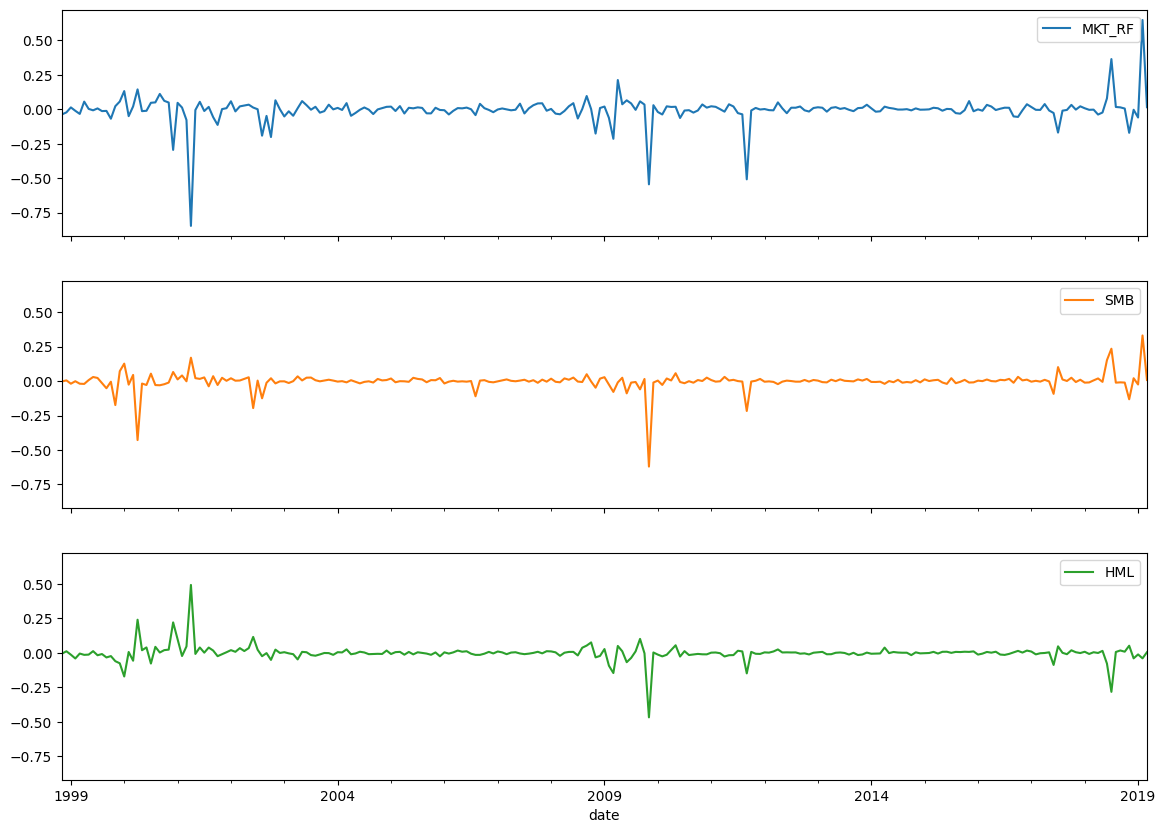

In [95]:
gammas_mat.iloc[:,1:4].plot( figsize=(14,10), subplots=True, sharey=True, sharex=True)
plt.show()

### 3.2.6 Factor competition

In [96]:
df_res_full=[]
for i in range(0,5):
    factors_list_full = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]
    factors_list_tmp=factors_list_full
    Y=FF_factors[factors_list_full[i]]
    factors_list_tmp.remove(factors_list_full[i])
    data=FF_factors[factors_list_tmp]
    results=sm.OLS(endog=Y,exog=sm.add_constant(data)).fit()
    results_param=results.params
    reg_result_tmp=pd.DataFrame(results_param)
    reg_result_tmp['factor_mnemo']=Y.name
    reg_result_tmp['pvalue']=results.pvalues
    df_res_full.append(reg_result_tmp)

df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
df_res_full.rename(columns={0: "coeff"},inplace=True)

In [97]:
df_significance = df_res_full
conditions = [
    (df_significance['pvalue'] > 0) & (df_significance['pvalue'] < 0.001),
    (df_significance['pvalue'] > 0.001) & (df_significance['pvalue'] < 0.01),
    (df_significance['pvalue'] > 0.01) & (df_significance['pvalue'] < 0.05),
    (df_significance['pvalue'] > 0.05)
]

values = ['(***)', '(**)', '(*)', 'na']

# Use np.select with a string default value to match the choices dtype
df_significance['significance'] = np.select(conditions, values, default='na')
df_significance['coeff'] = round(df_significance.coeff, 3)
df_significance['coeff_stars'] = df_significance.coeff.astype(str) + ' ' + df_significance.significance

# Display updated DataFrame in the right shape
factors_list_full = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]
df_significance_pivot = df_significance.pivot(index='index', columns='factor_mnemo', values='coeff_stars').transpose()
column_names_inverted = ["const", "MKT_RF", "SMB", "HML", "RMW", "CMA"]
df_significance_pivot = df_significance_pivot.reindex(columns=column_names_inverted)
df_significance_pivot.reindex(factors_list_full)

index,const,MKT_RF,SMB,HML,RMW,CMA
factor_mnemo,,,,,,
MKT_RF,0.009 (***),NaN,0.005 na,0.507 (***),-0.768 (***),-0.746 (***)
SMB,0.004 (*),0.003 na,NaN,0.129 na,-0.601 (***),0.162 na
HML,-0.003 (*),0.181 (***),0.082 na,NaN,0.444 (***),0.871 (***)
RMW,0.005 (***),-0.257 (***),-0.358 (***),0.417 (***),NaN,-0.109 na
CMA,0.002 (*),-0.134 (***),0.052 na,0.437 (***),-0.058 na,NaN


## 3.4 Hot Topics: momentum, timing and ESG
### 3.4.1 Factor momentum

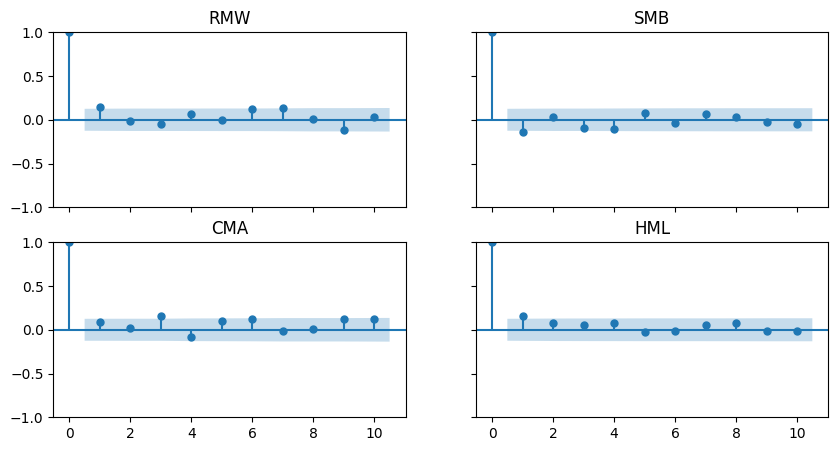

In [98]:
fig, ax = plt.subplots(2,2,figsize=(10,5),sharex='all', sharey='all')
sm.graphics.tsa.plot_acf(FF_factors.RMW, lags=10, ax=ax[0,0],title='RMW')
sm.graphics.tsa.plot_acf(FF_factors.CMA, lags=10, ax=ax[1,0],title='CMA')
sm.graphics.tsa.plot_acf(FF_factors.SMB, lags=10, ax=ax[0,1],title='SMB')
sm.graphics.tsa.plot_acf(FF_factors.HML, lags=10, ax=ax[1,1],title='HML')
plt.show()

## 3.6 Coding Exercices

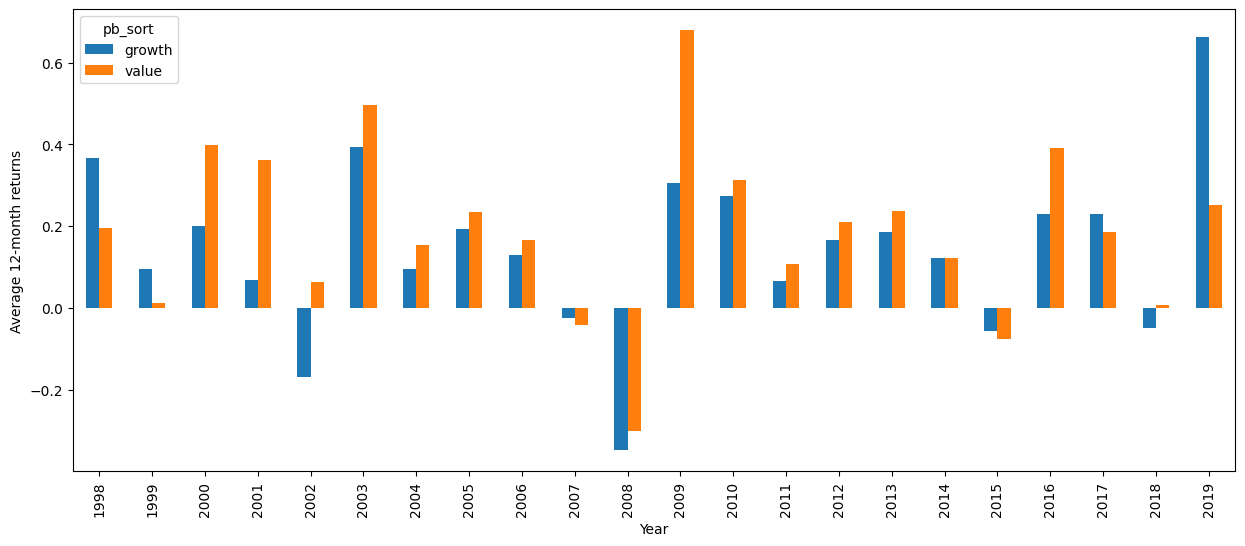

In [99]:
# 1. Compute annual returns of the growth versus value portfolios, that is,
#    the average return of firms with above median price-to-book ratio (the variable is called `Pb' in the dataset).

df_exo = data_ml[['stock_id','date','Pb','R1M_Usd']].copy()
df_exo['date'] = pd.to_datetime(df_exo['date'])
df_exo['R1M_USD_annualized'] = df_exo['R1M_Usd'] * 12
df_exo['pb_median'] = df_exo.groupby('date')['Pb'].transform('median')
df_exo['pb_sort'] = np.where(df_exo['Pb'] > df_exo['pb_median'], 'growth', 'value')
avg_ann_returns = df_exo.groupby([df_exo['date'].dt.year, 'pb_sort'])['R1M_USD_annualized'].mean().reset_index()
avg_ann_returns.pivot(index='date',columns='pb_sort',values='R1M_USD_annualized').plot.bar(figsize=(15,6))
plt.ylabel('Average 12-month returns')
plt.xlabel('Year')
plt.show()

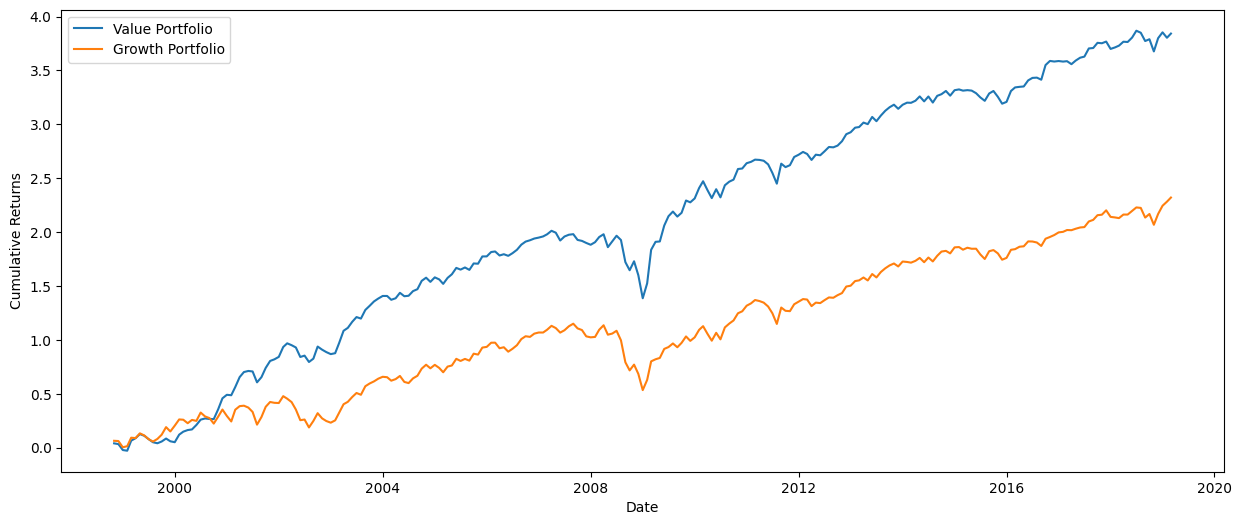

In [100]:
# 2. Same exercise, but compute the monthly returns and plot the value (through time) of the corresponding portfolios.

avg_monthly_returns = df_exo.groupby([df_exo['date'].dt.to_period('M'), 'pb_sort'])['R1M_Usd'].mean().reset_index()

avg_value_monthly_returns = avg_monthly_returns[avg_monthly_returns['pb_sort'] == 'value']
avg_growth_monthly_returns = avg_monthly_returns[avg_monthly_returns['pb_sort'] == 'growth']

cum_value_monthly_returns = (avg_value_monthly_returns.set_index('date')['R1M_Usd']).cumsum()
cum_growth_monthly_returns = (avg_growth_monthly_returns.set_index('date')['R1M_Usd']).cumsum()

plt.figure(figsize=(15,6))
plt.plot(cum_value_monthly_returns.index.to_timestamp(), cum_value_monthly_returns, label='Value Portfolio')
plt.plot(cum_growth_monthly_returns.index.to_timestamp(), cum_growth_monthly_returns, label='Growth Portfolio')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()

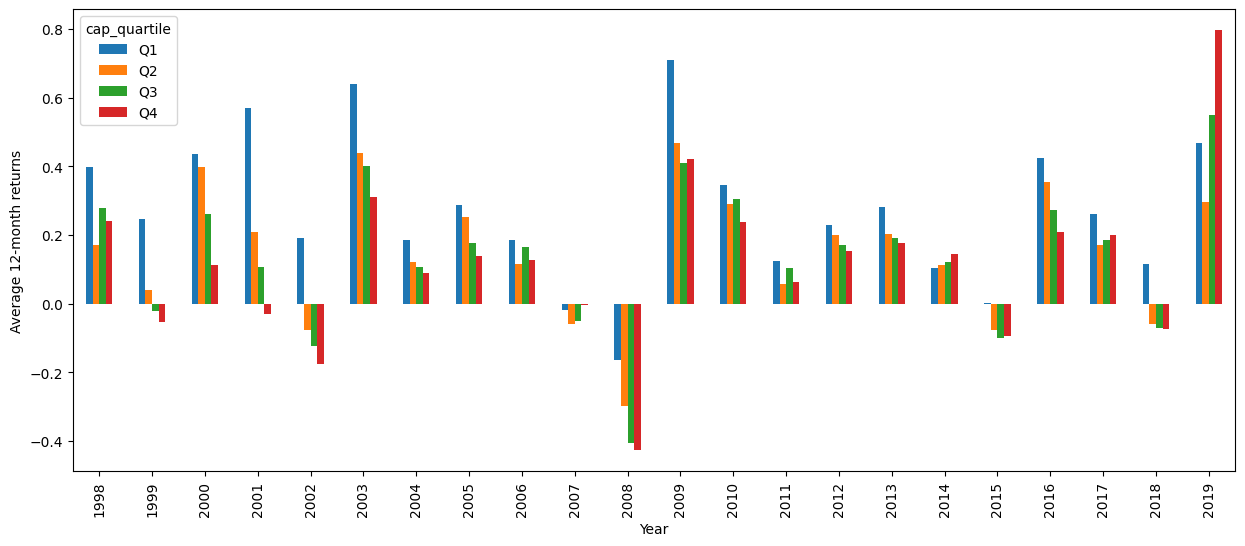

In [101]:
# 3. Instead of a unique threshold, compute simply sorted portfolios based on quartiles of market capitalization.
#    Compute their annual returns and plot them.

df_exo['Mkt_Cap_12M_Usd'] = data_ml['Mkt_Cap_12M_Usd'].copy()
df_exo['cap_quartile'] = pd.qcut(df_exo['Mkt_Cap_12M_Usd'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
avg_ann_returns_quartiles = df_exo.groupby([df_exo['date'].dt.year, 'cap_quartile'], observed=True)['R1M_USD_annualized'].mean().reset_index()
avg_ann_returns_quartiles.pivot(index='date',columns='cap_quartile',values='R1M_USD_annualized').plot.bar(figsize=(15,6))
plt.ylabel('Average 12-month returns')
plt.xlabel('Year')
plt.show()